Name(s):

# HW 6: Q-Learning and Association Analysis

## Part 1: Q-Learning

For the first part of this assignment, you'll code an ML agent that uses Q-Learning to learn how to play Snake.

<img src="snake_game.jpg" width="300"/>


If you are not familiar with the game of Snake, read about how the game is played, and even play it yourself, [here](https://www.coolmathgames.com/blog/how-to-play-snake-mastering-a-classic). 

Once you understand how to play the game, continue with the assignment!

#### Imports

In [5]:
# you will need pygame installed
!pip install pygame

In [6]:
import pygame
import random
import numpy as np

import pickle as pkl
import itertools

# the environment is provided in game_loop.py
from game_loop import *

pygame 2.6.1 (SDL 2.28.4, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
imported game_loop


### Game States
For Q-Learning, the agent needs to keep a Q-Table of game states. To keep the number of possible game states manageable, we will define the game state as a combination of:
* Horizontal orientation from the food - is the food currently to the left or the right of the snake's head? (-1: left, 0: same, 1: right)
* Vertical orientation from the food - is the food currently above or below the snake's head? (-1: below, 0: same, 1: above) 
* What are in the squares adjacent to the snake's head - are there walls or snake tail in these squares? (1 indicates something is there, 0 indicates it is open)

The environment (which is in the provided `game_loop.py` file) will provide this state in the form of two tuples:
- The first tuple will contain (relative horizontal orientation to food, relative vertical orientation to food).
- The second tuple will contain the squares surrounding the snake's head in the form of (up, down, left, right) where a 1 indicates wall or tail is in that square and 0 indicates that square is open.

### Snake Agent
Below is a provided class for the SnakeAgent that will learn to play the game, using Q-Learning. 

Some methods have been provided for you - **do not change these**:
* `__init__`: The constructor sets up some constants and sets the learning parameter values. Do not change the learning parameter values for part 1 of this assignment. It also calls init_qtable to initialize the Q-Table. 
* `init_qtable`: Initializes the Q-Table. The `qtable` is implemented as a dictionary of state -> list of four Q-Values, representing the four action choices of [left, right, up, down].
* `save` and `load`: Saves the Q-Values (via pickle) so the agent can be re-loaded later via load.

There are two additional methods in the SnakeAgent class **that you will implement**. These will be called by the `game_loop.py` file.
* `act`: This method is responsible for selecting an action based on the current state.
* `update`: This where the Q-values get updated based on the agent's actions and rewards during gameplay.


### Implementation

Q1. Implement the `act` method in the SnakeAgent class.

The `act` method is responsible for selecting an action based on the current state, which is determined by the Snake's position and the relative position of the food. The agent can choose to explore randomly with a probability of epsilon or to exploit the learned Q-values to select the next action.

In this method, you should:
- Based on the current state, choose an action using an epsilon-greedy strategy
  - Explore: Select a random action (0: left, 1: right, 2: up, 3: down)
  - Exploit: Select the action with the highest Q-value for the current state
- Record the current state and action, as you'll need these later for the update method (use `self.curr_state` and `self.curr_act`)
- Return the chosen action as a string (use `self.ACTION_STRING_MAP` in the SnakeAgent class)

Q2. Implement the `update` method in the SnakeAgent class.

The `update` method is a critical part of your SnakeAgent's learning process. It's where you update the Q-values based on the agent's actions and rewards during gameplay. Follow these steps to implement the `update` function:

**Rewards**:
Positive rewards are given for favorable actions, and negative rewards are given for unfavorable ones.
- Check if the game is over using the `game_over` parameter. If it is over, give the agent a reward of -10 to indicate that the agent has lost the game.
- If the game is not over, calculate the reward as follows: 
    - If the snake got closer to the food or if it ate the food, then set the reward to +1. 
    - If the snake got farther from the food or did not eat the food, then set the reward to -1.
You can use `self.curr_dist_from_food` and the incoming parameter from the environment `dist_from_food` to help you determine this.
    
**Update the Q-value for the state-action pair**:
- With the current state and action, update the Q-value for this state-action pair using the Q-learning formula, where `max(Q(s_t_plus_1))` is the maximum Q-value for the next state:
$$
Q(s_t, a_t) = Q(s_t, a_t) + \alpha \cdot (R_t + \gamma \cdot \max_a Q(s_{t+1}, a) - Q(s_t, a_t))
$$

In [7]:
class SnakeAgent(object):
    '''
    Do not change this code, except for the 'act' and 'update' methods.
    '''
    def __init__(self, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE):

        self.ACTION_STRING_MAP = {0: "left", 1: "right", 2: "up", 3: "down"}

        # Learning parameters - do not change these for Part 1
        self.epsilon = 0.1 # exploration rate
        self.alpha = 0.7 # learning rate
        self.gamma = 0.5 # discount factor

        # Initialize the Q-Table
        self.init_qtable()
        
        # State/Action history
        self.curr_state = None
        self.curr_act = None
        self.curr_dist_from_food = 1000

    def init_qtable(self):
        '''Initialize the qtable to all 0s'''
        self.qtable = {}
        REL_Y = [-1, 0, 1] # [below, same, above]
        REL_X = [-1, 0, 1] # [left, same, right]
        SURROUNDINGS = list(itertools.product(*[[0,1]] * 4)) # [0, 1] possibilities for surrounding block in each direction
        for y in REL_X:
            for x in REL_Y:
                for s in SURROUNDINGS:
                    self.qtable[QState((x, y), tuple(s))] = [0, 0, 0, 0] # q values for actions [left, right, up, down]

    def load(self, path="qtable.pkl"):
        return pkl.load(open(path, "rb"))

    def save(self, path="qtable.pkl"):
        pkl.dump(self.qtable, open(path, "wb"))
        
    
    '''
    Implement these methods:
    '''
    def act(self, state):
        # select explore or exploit based on
        number = random.random()
        if number <= self.epsilon: # random/explore
            indx = random.randint(0,3)
        else: # explot based on highest q value
            state_qs = self.qtable[state]
            indx = np.argmax(state_qs)
        self.curr_act = indx
        self.curr_state = state
        return self.ACTION_STRING_MAP[indx]    
    def update(self, game_over, dist_from_food, new_state):  
        # next state is the state we transitioned just transitioned to thus we are only editing q relating to our action 
        reward = 0
        if game_over:
            reward = -10
        else: # game not over
            if self.curr_dist_from_food > dist_from_food:
                reward = 1
            else:
                reward = -1

        new_state_qvalues =  self.qtable.get(new_state)
        max_next_q = max(new_state_qvalues)
        self.qtable[self.curr_state][self.curr_act] += self.alpha * (reward + self.gamma * max_next_q - self.qtable[self.curr_state][self.curr_act])
        self.curr_dist_from_food = dist_from_food

        



### Game Loop
The code in this cell will kick off the game, using your SnakeAgent, and will let your agent play for the specified number of eqisodes, keeping track of the scores as your agent learns how to play. 

In [8]:
'''
Do not change the code in this cell!
(except for setting draw=False if you want to turn off the game visualization)
'''

pygame.init()

BLOCK_SIZE = 10 
DIS_WIDTH = 600
DIS_HEIGHT = 500
FRAMESPEED = 50000
NUM_EPISODES = 200

#create a SnakeAgent
agent = SnakeAgent(DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE)

game_count = 1
max_score = 0

# loop for specified number of episodes
for i in range(NUM_EPISODES):
    # use a decaying epsilon rate
    if game_count > 100:
        agent.epsilon = .01
    else:
        agent.epsilon = .1
        
    # Start the game
    # (To turn off the game visualizations, you can set draw=False)
    score = GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
    
    max_score = max(max_score, score)
    print(f"Games: {game_count}; Score: {score}; Max Score: {max_score}") # Output results of each game to console to monitor as agent is training
    game_count += 1

agent.save()
print("Save Qvals")
pygame.quit()

Games: 1; Score: 1; Max Score: 1
Games: 2; Score: 1; Max Score: 1
Games: 3; Score: 1; Max Score: 1
Games: 4; Score: 1; Max Score: 1
Games: 5; Score: 1; Max Score: 1
Games: 6; Score: 1; Max Score: 1
Games: 7; Score: 1; Max Score: 1
Games: 8; Score: 1; Max Score: 1
Games: 9; Score: 1; Max Score: 1
Games: 10; Score: 1; Max Score: 1
Games: 11; Score: 1; Max Score: 1
Games: 12; Score: 1; Max Score: 1
Games: 13; Score: 1; Max Score: 1
Games: 14; Score: 2; Max Score: 2
Games: 15; Score: 1; Max Score: 2
Games: 16; Score: 1; Max Score: 2
Games: 17; Score: 1; Max Score: 2
Games: 18; Score: 3; Max Score: 3
Games: 19; Score: 3; Max Score: 3
Games: 20; Score: 1; Max Score: 3
Games: 21; Score: 1; Max Score: 3
Games: 22; Score: 1; Max Score: 3
Games: 23; Score: 1; Max Score: 3
Games: 24; Score: 1; Max Score: 3
Games: 25; Score: 1; Max Score: 3
Games: 26; Score: 1; Max Score: 3
Games: 27; Score: 1; Max Score: 3
Games: 28; Score: 2; Max Score: 3
Games: 29; Score: 2; Max Score: 3
Games: 30; Score: 1; Ma

#### Saving and loading the trained agent
The code above above saves your trained agent. You can use the cell below to load your trained agent and run it (so you don't have to re-train it).

In [9]:
agent.load()
pygame.init()
GameLoop(agent, DIS_WIDTH, DIS_HEIGHT, BLOCK_SIZE, FRAMESPEED, draw=True)
pygame.quit()

### Extra Credit (+5)
Improve the Agent's Performance. Can you get a max score above 80 within 300 episodes? 
Potential ideas: improve the state representation, change the reward function, change the hyperparameters, etc.

**Copy the SnakeAgent class from above and paste a copy of it in a new cell (you can make a new cell between the SnakeAgent class and the GameLoop cell). Make any extra credit adjustments to the copy, preserving your original SnakeAgent class so that Q1 and Q2 can be graded.**
- Write in a markdown cell what you changed and what your observations were

## Part 2: Association Analysis

Association analysis uses machine learning to extract frequent itemsets and strong association rules from large datasets. In this assignment you'll be implementing one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

The dataset (`large_retail.txt`) that we are going to use has been adapted from the [Retail Market Basket Dataset](http://fimi.ua.ac.be/data/retail.pdf). This dataset contains transaction records supplied by a Belgian retail supermarket store. Each line in the file represents a separate transaction with the item ids separated by space. The dataset has 3000 transactions and 99 different item ids.

You are also provided with a smaller dataset (`small_retail.txt`) with 9 transactions and 5 different item ids. You can test and debug your implementation on this smaller dataset.

### Apriori Algorithm from scratch

The Apriori algorithm is a classical algorithm in data mining. It is used for mining frequent itemsets and relevant association rules. In this part, you'll be implementing this algorithm for generating the itemsets that occur enough times to meet the `min_sup` threshold.

- Use the `frozenset` data structure in Python, which is similar to `set` in functionality, to represent the itemsets, because `frozenset` is an immutable (hashable) data structure. You can maintain a dictionary that maps from the itemset (a `frozenset`) to its support count.

In [65]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()
        data = [[int(x) for x in line.rstrip().split()] for line in content]
    return data

In [66]:
# Read in the small_retail dataset
small_dataset = load_dataset('small_retail.txt')
small_dataset

[[1, 2, 5],
 [2, 4],
 [2, 3],
 [1, 2, 4],
 [1, 3],
 [2, 3],
 [1, 3],
 [1, 2, 3, 5],
 [1, 2, 3]]

Q3. Implement the function `create_1_itemsets` that takes as input the entire dataset and returns a list of all the candidate 1-itemsets. For example, for `small_retail.txt` it should return:
~~~
[frozenset({1}),
 frozenset({2}),
 frozenset({3}),
 frozenset({4}),
 frozenset({5})]
 ~~~
Don't hardcode the item ids, your code should support item ids that are non-sequential. Return the list in sorted (numeric) order.

In [67]:
def create_1_itemsets(dataset):
    c1 = []
    big_list = []
    for list in dataset:
        big_list += list
    big_list = set(big_list) # eliminate duplicates
    big_list = sorted(big_list) # sort
    for item in big_list: # convert to small sets
        c1.append(frozenset({item}))
    return c1

create_1_itemsets(small_dataset)

[frozenset({1}),
 frozenset({2}),
 frozenset({3}),
 frozenset({4}),
 frozenset({5})]

Q4. Implement function `filter_candidates` that takes as input the candidate itemsets, the dataset, and the minumum support count `min_sup`, and filters out candidates that don't meet the support threshold.

Return a list of all the itemsets that meet `min_sup` (as a list of frozensets) and the support count information for all of them (as a `dict`).

In [68]:
# has not been tested
def filter_candidates(candidates, dataset, min_sup):
    retlist = []
    support_data = {}
    for candidate in candidates:
        support = 0
        for item_list in dataset:
            item_list = set(item_list)
            if candidate in item_list:
                support +=1
        if support >= min_sup: # might need to change support to fraction instead of intss                
            retlist.append(candidate)
            support_data[candidate] = support
    return retlist, support_data

Q5. Implement the function `generate_next_itemsets` that takes in frequent itemsets of size `k` and generates candidate itemsets of size `k + 1`.

Use either the F(k-1) x F(k-1) or the F(k-1) x F(1) candidate generation method, then **filter the candidate list based on the apriori principle before returning it.**

In [69]:
def generate_next_itemsets(freq_sets, freq_1_sets=None):
    retlist = []
    k = len(freq_sets[0])
    for i in range(len(freq_sets)):
        for j in range(i+1,len(freq_sets)):
            set_1 = freq_sets[i]
            set_2 = freq_sets[j]
            union_set = set_1.union(set_2)
            if (len(union_set) == k+1):
                # combinations creates all possibe k combinations and converts it to a set. Check if its in freq_sets
                if all(subset in freq_sets for subset in map(set, itertools.combinations(union_set, k))):
                    retlist.append(union_set)    
    return retlist

Q6. Implement the function `apriori_freq_itemsets` that takes the entire dataset as input and returns all the frequent itemsets that meet `min_sup`. Return a list of all the itemsets that meet `min_sup` (as a list of frozensets) and the support count information for all of them (as a `dict`).

In [70]:
def apriori_freq_itemsets(dataset, minsup):
    retlist = []
    support_data = {}
    # your code goes here
    freq_sets = create_1_itemsets(dataset)
    
    while generate_next_itemsets(freq_sets):
        retlist, support_data = filter_candidates(freq_sets, dataset, minsup)
        freq_sets = generate_next_itemsets(freq_sets)

    return retlist, support_data

Q7. Use the provided `print_itemsets` function to display the frequent itemsets and their supports for the `large_retail.txt` dataset **with a min_support count of 300**.

For testing/debugging purposes, the output for the `small_retail.txt` dataset with `min_sup` set to 2 is:
~~~~
Sup	Freq Itemset
6	[1]
7	[2]
6	[3]
2	[4]
2	[5]
4	[1, 2]
4	[1, 3]
2	[1, 5]
4	[2, 3]
2	[2, 4]
2	[2, 5]
2	[1, 2, 3]
2	[1, 2, 5]
~~~~

In [71]:
# DO NOT CHANGE THE CODE IN THIS CELL

'''
If total_tid is not set, support count will be displayed.
If total_tid is set to the length of the dataset, support as a percentage/ratio will be displayed.
'''
def print_itemsets(support_data, total_tid=1):
    print ('\nSup\tFreq Itemset')
    #group itemsets by length
    length_dict = {}
    
    for itemset in support_data:
        #sort the itemset
        lst = (sorted(list(itemset)))
        #add it to dictionary by length
        if len(lst) not in length_dict:
            length_dict[len(lst)] = []
        length_dict[len(lst)].append(lst)

    for length in length_dict:
        lst = sorted(length_dict[length])
        for item in lst:
            if total_tid == 1: #support count
                print(str(support_data[frozenset(item)]) + '\t' + str(item))
            else: #support ratio
                print(str(round(support_data[frozenset(item)] / total_tid, 2)) + '\t' + str(item))

In [72]:
# your code goes here
print_itemsets(apriori_freq_itemsets(small_dataset, minsup=2))


Sup	Freq Itemset


TypeError: tuple indices must be integers or slices, not frozenset

## Part 3: Apriori Algorithm using MLXtend

#### Installation
`MLxtend` is a library that provides functionality for association rule mining. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

In [52]:
# install the MLxtend library
!pip install mlxtend

In [53]:
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

%matplotlib inline

### Dataset
For the third part of this assignment, the data we'll use comes from a bakery called "The Bread Basket", located in the historic center of Edinburgh. The dataset contains more than 9000 transactions from the bakery. The file contains the following columns:

- Date. Categorical variable that tells us the date of the transactions (YYYY-MM-DD format). The column includes dates from 2016-10-30 to 2017-04-09.

- Time. Categorical variable that tells us the time of the transactions (HH:MM:SS format).

- Transaction. Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction.

- Item. Categorical variable with the products purchased.

In this part, you'll be running the Apriori algorithm from the MLxtend library to generate the itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets, you'll find association rules that have confidence above the `min_conf` threshold.

In [54]:
# Reading the dataset from file
def load_dataset(file_name):
    with open(file_name, 'r') as f:
        content = f.readlines()[1:]
    transactions = []
    prev_tid = -1
    for t in content:
        t = t.strip().split(',')[-2:]
        tid = t[0]
        item = t[1]
        if prev_tid != tid:
            prev_tid = tid
            transactions.append([item])
        else:
            transactions[-1].append(item)
    return transactions

In [55]:
dataset = load_dataset('BreadBasket_DMS.csv')

# ** NOTE: dataset is a 2D list (not a dataframe!) **

print("Num transactions:", len(dataset))
#Print the first 10 transactions
dataset[:10]

Num transactions: 9531


[['Bread'],
 ['Scandinavian', 'Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna']]

Q8. Data Cleaning: Many transactions in the dataset include the item "NONE." First, find and remove all the "NONE" items from the dataset. There are some transactions that only contain "NONE," so removing "NONE" will leave some transactions as empty lists. Remove all the empty lists as well. 

Once you have removed the NONEs, find the top 10 best-selling items in the bakery. Create a bar chart to display the total number of transactions for each of the top 10 selling items. Sort the bar chart by frequency (the top most sold item first, down to the 10th most sold item).

0
0


,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9460,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9461,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
9462,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9463,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Coffee           4528
Bread            3097
Tea              1350
Cake              983
Pastry            815
Sandwich          680
Medialuna         585
Hot chocolate     552
Cookies           515
Brownie           379
dtype: int64

4528


<BarContainer object of 10 artists>

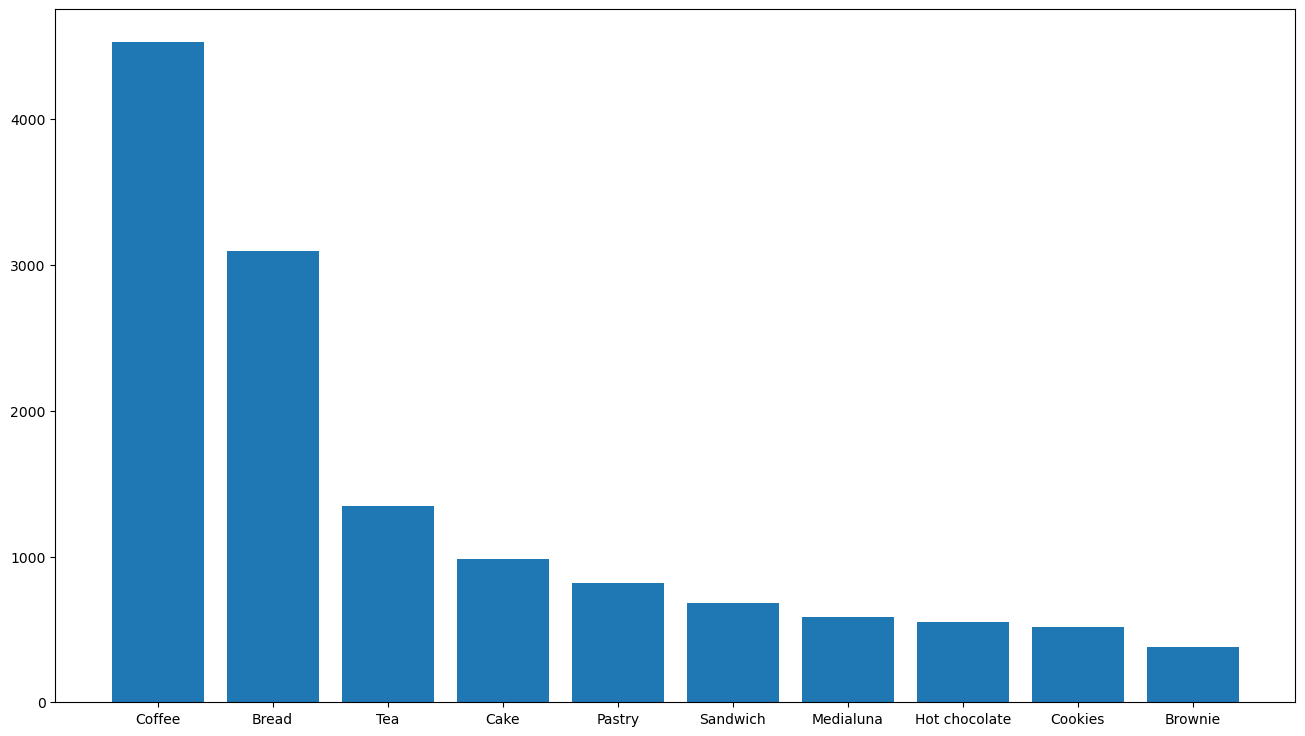

In [110]:
# your code goes here
import pandas as pd
import matplotlib.pyplot as plt 

counter = 0
for i in dataset:
  for j in i:
    if j == 'NONE':
      i.remove(j)
      counter += 1
  if i == []:
    dataset.remove(i)
    counter += 1
print(counter)

counter = 0
for i in dataset:
  if 'NONE' == i or i == []:
    print(i)
    counter += 1
print (counter)

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
display(df)
frequency = df.sum().sort_values(ascending=False)
display(frequency.head(10))
print(frequency.head(10)[0])
plt.figure(figsize=[16,9])
plt.bar(frequency.head(10).index,frequency.head(10))

Q9. 

a.) Using `mlxtend.preprocessing.TransactionEncoder`, transform `dataset` into an array format suitable for the `mlxtend` library. You will need to call `fit` then `transform`. 

`TransactionEncoder` learns unique items from the dataset and transforms each transaction into a one-hot encoded boolean numpy array. For example, the resulting encoded dataset will be represented by something like this, where each row is a transaction. If the first transaction contained ['Crepe', 'Jam'], this would correspond to the first row in the encoded table. 

<img src="table.png">

Print the `shape` of the resulting encoded numpy array.

b.) `TransactionEncoder` also has a function `inverse_transform` that allows you to tranform one-hot encoded transactions back to the item labels. Try it out on the first 5 transactions and display the items in the first 5 transactions.

In [57]:
# your code goes here
te = TransactionEncoder()
dataset2 = te.fit(dataset).transform(dataset)
display(dataset2.shape)

te.inverse_transform(dataset2[0:5])

(9472, 95)

[['Bread'],
 ['Scandinavian'],
 ['Cookies', 'Hot chocolate', 'Jam'],
 ['Muffin'],
 ['Bread', 'Coffee', 'Pastry']]

Q10. Convert the encoded numpy array from the previous question (part a) into a pandas dataframe. Use the `TransactionEncoder`'s `.columns_` attribute as the column headers. Print the head of the resulting dataframe. 

In [74]:
# your code goes here
df = pd.DataFrame(dataset2, columns=te.columns_)
df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Q11. Use the `mlxtend.frequent_patterns.apriori` to generate the frequent itemsets with minimum support of 1% (0.01). Display these itemsets along with their support values.

In [111]:
# your code goes here
sets = apriori(df, 0.01, use_colnames=True)
display(sets)

,support,itemsets
0,0.036344,(Alfajores)
1,0.016059,(Baguette)
2,0.327205,(Bread)
3,0.040042,(Brownie)
4,0.103856,(Cake)
...,...,...
56,0.023666,"(Coffee, Toast)"
57,0.014369,"(Tea, Sandwich)"
58,0.010037,"(Coffee, Bread, Cake)"
59,0.011199,"(Coffee, Bread, Pastry)"


Q12. Use `mlxtend.frequent_patterns.fpmax` to find and display all of the maximal frequent itemsets along with their support values. 

In [85]:
# your code goes here
from mlxtend.frequent_patterns import fpmax
freq = fpmax(df, min_support=0.01, use_colnames=True)
display(freq)

,support,itemsets
0,0.010452,(Salad)
1,0.010557,(Hearty & Seasonal)
2,0.012986,(Chicken Stew)
3,0.013197,(Jammie Dodgers)
4,0.014147,(Mineral water)
5,0.014992,(Jam)
6,0.014992,(Fudge)
7,0.015414,(Tiffin)
8,0.016047,(Baguette)
9,0.010874,"(Coffee, Spanish Brunch)"


Q13. Use `mlxtend.frequent_patterns.association_rules` to calculate rules with a confidence level of 0.25 for the frequent itemsets you generated in Q11.

In [114]:
# your code goes here
from mlxtend.frequent_patterns import association_rules

association_rules(freq, len(freq), metric="confidence", min_threshold=0.25)

KeyError: "frozenset({'Coffee'})You are likely getting this error because the DataFrame is missing  antecedent and/or consequent  information. You can try using the  `support_only=True` option"

Q14. An important step in generating a set of association rules is to determine the optimal thresholds for support and confidence. If we set these values too low we will get a lot of rules and most of them will not be useful. 

Generate the frequent itemsets with minimum support of 0.5% and plot the number of rules generated with respect to the confidence threshold by varying min_conf between 0 and 1 with increments of 0.1. Notice what happens when you increase the confidence level.

In [62]:
# your code goes here

Q15. What value would you choose for the minimum confidence threshold based on the previous plot? Explain why as a comment. 

Display the rules generated for the your chosen value. Take a look at the generated rules. Are they interesting? As a comment, explain why or why not.

In [63]:
# your code goes here